<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC2</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Transformers

En esta práctica introduciremos el modelo de aprendizaje profundo basado en _transformer_ y lo aplicaremos en dos problemas relacionados con el procesamiento de lenguage natural. 

<u>Consideraciones generales</u>: 

- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

# 0. Introducción
Esta PEC constará de dos ejercicios independientes: 
- En el primero se aplicarán los modelos de transformers a un problema de análisis de sentimiento en textos cortos de twitter,
- En el segundo ejercicio se aplicará este tipo de algorítmos para entrenar un traductor de inglés a francés.

La PEC se puede ejecutar en GPU (opción preferente) o en CPU. Como referencia, el apartado computacionalmente más costoso puede tardar alrededor un par de horas en un computador moderno con un chip i7 reciente. En cualquier caso, estos tiempos meramente orientativos y dependerán de la implementación y del hardware disponible.

# 1. Carga y preprocesado de la base de datos Sentiment 140 (2 puntos)
La base de datos [Sentiment 140](https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf) se compone de más de 1 millón de tweets que se han clasificado en función de si el mensaje es negativo (0) o positivo (4). El dataset se puede descargar desde la página de kaggle dedicada a ello:
- https://www.kaggle.com/datasets/kazanova/sentiment140

El objetivo de este ejercicio es entrenar un modelo que, dada una frase cualquiera, sea capaz de predecir si el mensaje es negativo o positivo. Las etapas del ejercicio serán las siguientes:
* Carga, preprocesado, exploración y visualización de los datos. 
* Entrenamiento de un modelo tradicional basado en una RNN o LSTM.
* Entrenamiento de una red que incluya Transformers.
* Optimización automática de los hyperparámetros del Transformer.
* Escalado de la arquitectura y mejora de los resultados. 


In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, TextVectorization

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from IPython.display import clear_output

import optuna
import pathlib
import random
import string
import re

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)


## 1.1. Carga y visualizacion de los datos (2 puntos)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Descarga la base de datos, cargalá con Python, aleatoriza el orden de las filas del dataset y realiza un histograma del número de tweets positivos y tweets negativos.</p>
</div>

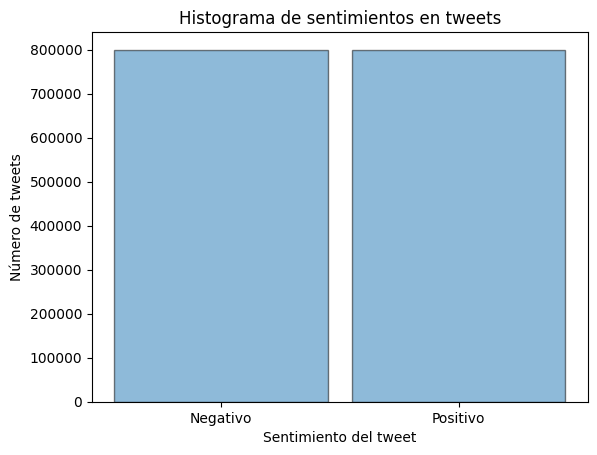

In [ ]:
# Ruta al csv
home =  '/kaggle/input/sentiment140/'
# Especificamos las columnas ya que la primera fila no es el header
columns = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(home+'training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=columns)
# Aleatorizamos el orden
df = df.sample(frac=1, random_state=123).reset_index(drop=True)
# Histograma tweets positivos y negativos
plt.hist(df['target'], bins=2, alpha=0.5,  rwidth=0.9, edgecolor='black')
plt.xticks([1,3], ['Negativo', 'Positivo'])
plt.xlabel('Sentimiento del tweet')
plt.ylabel('Número de tweets')
plt.title('Histograma de sentimientos en tweets')
plt.show()

## 1.2. Visualización de los tweets y procesado del texto

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Muesta 5 tweets distintos, comprobarás que aparecen símbolos de puntuación, palabras en minúsculas o mayúsculas, etc. Realiza una limpieza y estandarización preliminar de todo el texto y luego cuenta las veces que aparece cada palabra y ordenálas. A la palabra que más veces aparece se le asigna el número 1, la siguiente el 2, etc. Representa en escala logarítmica la frequencia de apareción versus el número asignado.</p>
</div>

In [ ]:
# Podemos mostrar los primeros 5 tweets ya que es aleatorizado
df.head(5)

,target,ids,date,flag,user,text
0,0,2068921155,Sun Jun 07 14:56:42 PDT 2009,NO_QUERY,smiley_sophie,my arm still hurts from when i pulled it yeste...
1,4,2065871668,Sun Jun 07 09:27:21 PDT 2009,NO_QUERY,ImmaChocoholic,I have so much to do outside! Been looking at ...
2,0,1835774749,Mon May 18 06:43:27 PDT 2009,NO_QUERY,drmomentum,"@AbsolutSara Yes, I knew about the clusterfark..."
3,0,1967121891,Fri May 29 19:00:46 PDT 2009,NO_QUERY,sweetsheilx,Just woke up and i feel relieved Haha now i ha...
4,4,1695846172,Mon May 04 07:04:29 PDT 2009,NO_QUERY,monmariej,LOVING the hot weather forecast for the rest o...


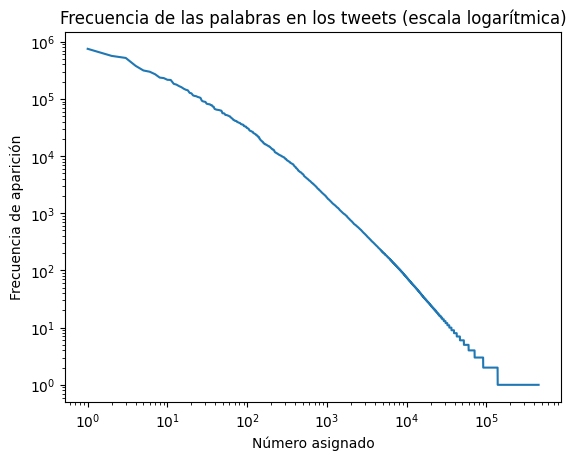

In [ ]:
from collections import Counter

# Limpieza preliminar del texto
def limpiar_texto(texto):
    # Eliminamos mencions, enlaces, y carácteres no ASCII y ponemos todo a minusculas.
    texto = re.sub(r'@\S+|http\S+|[^\w\s]', '', str(texto).lower())
    return texto

df['processed_text'] = df['text'].apply(limpiar_texto)

# Creamos una lista palabras para todos los tweets
palabras = []
for texto in df['processed_text']:
    palabras.extend(texto.split())

# Contamos la frecuencia de cada palabra
frecuencias = Counter(palabras)
# Asignamos 1 para la que más aprece, 2 para la siguiente...
numeros = range(1, len(frecuencias) + 1)

# Grafica en escala logarítmica
plt.loglog(numeros, sorted(frecuencias.values(),reverse=True))
plt.xlabel('Número asignado')
plt.ylabel('Frecuencia de aparición')
plt.title('Frecuencia de las palabras en los tweets (escala logarítmica)')
plt.show()

## 1.3. Procesado de las etiquetas y tokenización

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Como habrás observado, el lenguaje natural está muy desbalanceado, unas pocas palabras aparecen muchas veces y muchas palabras aparecen en pocas ocasiones. Esta información la tendremos en cuenta para construir posteriormente nuestros vocabulario de tokens, descartando palabras que aparecen poco.
    
Ahora nos vamos a quedar únicamente 20000 frases de todo el dataset. Las etiquetas han de ser convertidas al formato adecuado y se procesaran los textos para obtenerlos en forma de tokens con la función Tokenizer de Tensorflow. Muestra un ejemplo de una frase tokenizada y decodificada de nuevo.

</div>

In [ ]:
# 20000 registros
df_small = df.sample(n=20000, random_state=123)
# La etiqueta 0 (tweets negativos) la podemos mantener, cambiamos el valor 4 (tweets positivos) por 0
df_small['target'] = df_small['target'].replace({4: 1})

# Obtenemos los tokens
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_small['processed_text'])
sequences = tokenizer.texts_to_sequences(df_small['processed_text'])

# Ejemplo frase tokenizada y decodificada
example_sequence = sequences[0]
example_text = tokenizer.sequences_to_texts([example_sequence])[0]
print(example_sequence)
print(example_text)

[23, 349, 7, 63, 3615, 14]
at least you had jammies on


## 1.4. Partición de los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Finalmente deja un 80% de los datos para train y el resto para test. Únicamente se utilizaran 3000 tokens distintos.</div>

Utiliza la función `tf.keras.utils.pad_sequences` para normalizar el tamaño de todas los mensajes tokenizados. El tamaño final será el tamaño del mensaje más largo. Muestra un ejemplo de una frase una vez que se ha aplicado esta función.

In [ ]:
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# Calculamos el mensaje más largo
max_length = max(len(seq) for seq in df_small['processed_text'])

X=df_small.processed_text
y=df_small.target

# Limitamos a 3000 tokens
num_words=3000
tok = Tokenizer(num_words=num_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = pad_sequences(sequences,maxlen=max_length)
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.2, random_state=123)

# 2. Clasificación de tweets (4 puntos)

## 2.1 Entrenando el modelo con una RNN o LSTM




<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Utilizando los conocimientos adquiridos hasta ahora, entrenar un modelo de análisis de sentimientos con con una RNN o LSTM. Se proporciona la capa de entrada para facilitar el procesado de los tokens. Representar la accuracy durante el entrenamiento y durante la validación.
Varía los parámetros o la configuración de la red para mejorar el resultado. Finalmente, muestra el mejor resultado obtenido sobre test.
</div>


In [ ]:
# Esta capa se proporciona para facilitar la tarea.
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
from tensorflow.keras.layers import LSTM, Activation, Dropout
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 168

# Definición modelo
inputs = layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
layer = LSTM(64)(x)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1)(layer)
outputs = Activation('sigmoid')(layer)
model_lstm = keras.Model(inputs=inputs, outputs=outputs)
model_lstm.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 168)]             0         
                                                                 
 token_and_position_embeddin  (None, 168, 168)         4020744   
 g_6 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 lstm (LSTM)                 (None, 64)                59648     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout_15 (Dropout)        (None, 256)               0   

In [ ]:
# Compilación y entrenamiento del modelo
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train, Y_train, epochs=10, validation_split=0.1, verbose=1)

# Evaluar modelo en test
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc_lstm)
print('Test loss:', test_loss_lstm)

Epoch 1/10
450/450 [==============================] - 17s 31ms/step - loss: 0.5597 - accuracy: 0.7036 - val_loss: 0.5351 - val_accuracy: 0.7244
Epoch 2/10
450/450 [==============================] - 6s 13ms/step - loss: 0.4402 - accuracy: 0.7918 - val_loss: 0.5161 - val_accuracy: 0.7444
Epoch 3/10
450/450 [==============================] - 6s 13ms/step - loss: 0.3716 - accuracy: 0.8256 - val_loss: 0.5523 - val_accuracy: 0.7531
Epoch 4/10
450/450 [==============================] - 5s 12ms/step - loss: 0.3130 - accuracy: 0.8572 - val_loss: 0.6617 - val_accuracy: 0.7531
Epoch 5/10
450/450 [==============================] - 5s 11ms/step - loss: 0.2615 - accuracy: 0.8807 - val_loss: 0.7649 - val_accuracy: 0.7381
Epoch 6/10
450/450 [==============================] - 5s 11ms/step - loss: 0.2155 - accuracy: 0.9015 - val_loss: 0.9396 - val_accuracy: 0.7394
Epoch 7/10
450/450 [==============================] - 5s 11ms/step - loss: 0.1676 - accuracy: 0.9250 - val_loss: 1.1040 - val_accuracy: 0.735

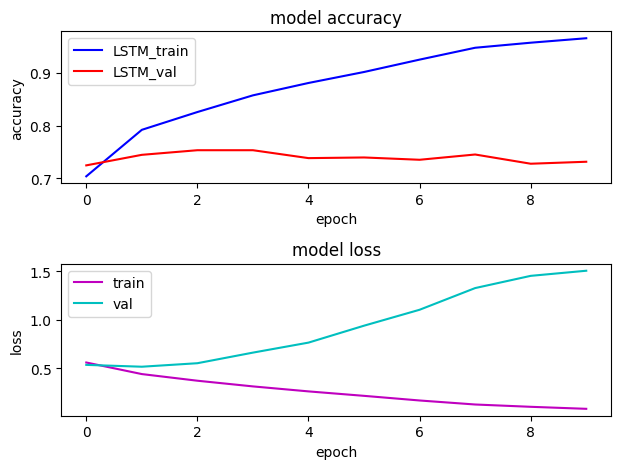

In [ ]:
def plot_history(history, model_name):
    s, (at, al) = plt.subplots(2,1)
    at.plot(history.history['accuracy'], c= 'b')
    at.plot(history.history['val_accuracy'], c='r')
    at.set_title('model accuracy')
    at.set_ylabel('accuracy')
    at.set_xlabel('epoch')
    at.legend([f'{model_name}_train', f'{model_name}_val'], loc='upper left')

    al.plot(history.history['loss'], c='m')
    al.plot(history.history['val_loss'], c='c')
    al.set_title('model loss')
    al.set_ylabel('loss')
    al.set_xlabel('epoch')
    al.legend(['train', 'val'], loc = 'upper left')
    plt.tight_layout()
plot_history(history_lstm,"LSTM")

## 2.2 Construye una red con dos capas de atención y entrena el modelo de nuevo

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Implementar una arquitectura basada en capas de atención que tendrá la siguiente estructura:
    
* La entrada primero se convierte a posicional embeddings con la función proporcionada TokenAndPositionEmbedding.
* Después habrá una capa MultiHeadAttention, seguida de un dropout y normalizacion
* Se añade otra capa MultiHeadAttention, seguida de un dropout y normalizacion.
* Despues añadir dos redes full connected, la primera con 32 neuronas y la segunda con 16.
* Finalmente añadir una capa de normalizacion, un droput, una capa de GlobalAveragePooling1D
    
Los dropouts serán del 20%, el numero de cabezas de la red Multihead será de 6


In [ ]:
class Transformer(layers.Layer):
    def __init__(self, sizedense, sizedense2, num_heads):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout1 = layers.Dropout(0.2)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout2 = layers.Dropout(0.2)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dense1 = layers.Dense(sizedense, activation="relu")
        self.dense2 = layers.Dense(sizedense2, activation="relu")
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout3 = layers.Dropout(0.2)
        self.pooling = layers.GlobalAveragePooling1D()
        self.output_layer = layers.Dense(1, activation="sigmoid")

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        x = self.att1(out1, out1)
        x = self.dropout2(x, training=training)
        x = self.layernorm2(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.layernorm3(x)
        x = self.dropout3(x, training=training)
        x = self.pooling(x)
        return self.output_layer(x)    
    
sizedense = 32 
sizedense2 = 16
num_heads = 6


inputs = layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer = Transformer(sizedense, sizedense2, num_heads)
outputs = transformer(x)

model_transformer = keras.Model(inputs=inputs, outputs=outputs)
model_transformer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168)]             0         
                                                                 
 token_and_position_embeddin  (None, 168, 168)         4020744   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer (Transformer)   (None, 1)                 1367793   
                                                                 
Total params: 5,388,537
Trainable params: 5,388,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilación y entrenamiento del modelo
model_transformer.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_transformer = model_transformer.fit(X_train, Y_train, epochs=10, validation_split=0.1, verbose=1)

# Evaluar modelo en test
test_loss_transformer, test_acc_transformer = model_transformer.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc_transformer)
print('Test loss:', test_loss_transformer)

Epoch 1/10
450/450 [==============================] - 57s 33ms/step - loss: 0.6949 - accuracy: 0.5061 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 2/10
450/450 [==============================] - 7s 15ms/step - loss: 0.6843 - accuracy: 0.5273 - val_loss: 0.6318 - val_accuracy: 0.6612
Epoch 3/10
450/450 [==============================] - 6s 13ms/step - loss: 0.5480 - accuracy: 0.7249 - val_loss: 0.5616 - val_accuracy: 0.7275
Epoch 4/10
450/450 [==============================] - 6s 13ms/step - loss: 0.4481 - accuracy: 0.7927 - val_loss: 0.5405 - val_accuracy: 0.7425
Epoch 5/10
450/450 [==============================] - 6s 13ms/step - loss: 0.3934 - accuracy: 0.8226 - val_loss: 0.5799 - val_accuracy: 0.7431
Epoch 6/10
450/450 [==============================] - 6s 13ms/step - loss: 0.3468 - accuracy: 0.8462 - val_loss: 0.5988 - val_accuracy: 0.7262
Epoch 7/10
450/450 [==============================] - 6s 13ms/step - loss: 0.3063 - accuracy: 0.8687 - val_loss: 0.6774 - val_accuracy: 0.726

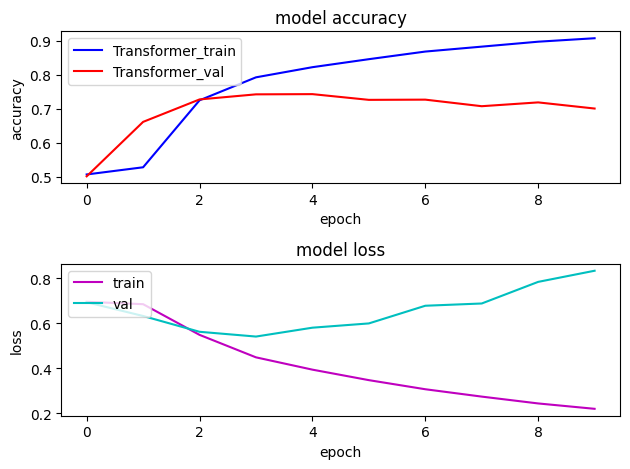

In [ ]:
plot_history(history_transformer,"Transformer")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Entrena el modelo anterior probando distintos batch sizes, evitando el overfitting y reportando las metricas de loss y accuracy durante el entrenamiento. Muestra finalmente el mejor resultado obtenido y comenta los resultados en comparación con los obtenidos anteriormente.

In [ ]:
# Definición modelo
embed_dim=16
inputs = layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer = Transformer(sizedense, sizedense2, num_heads)
outputs = transformer(x)

In [ ]:
from keras.callbacks import EarlyStopping
# Para evitar overfitting paramos con EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)

for batch_size in [16, 256, 1024]:
    model_transformer_new = keras.Model(inputs=inputs, outputs=outputs)
    model_transformer_new.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_transformer_new = model_transformer_new.fit(X_train, Y_train, batch_size=batch_size,
                                                        epochs=10, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    acc = max(history_transformer_new.history['val_accuracy'])
    loss = min(history_transformer_new.history['val_loss'])
    print(f"Mejor resultado para batch size {batch_size}: accuracy {acc} con una loss de {loss}\n")

Mejor resultado para batch size 16: accuracy 0.75 con una loss de 0.5288340449333191

Mejor resultado para batch size 256: accuracy 0.7556250095367432 con una loss de 0.5330247282981873

Mejor resultado para batch size 1024: accuracy 0.7568749785423279 con una loss de 0.5503252744674683



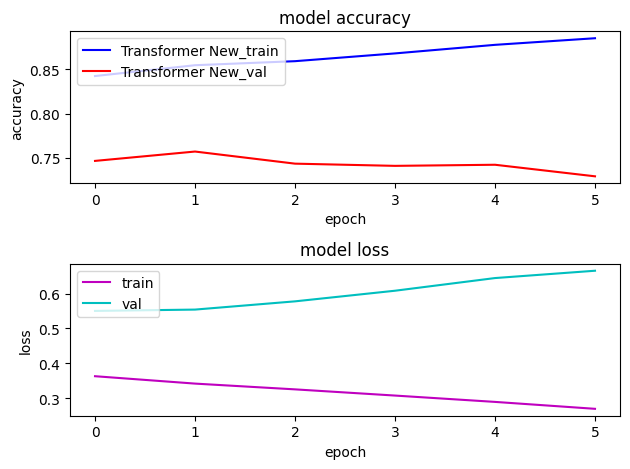

In [ ]:
plot_history(history_transformer_new,"Transformer New")

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
En general, los resultados obtenidos sugieren que el tamaño del batch tiene un leve impacto en la precisión del modelo. Se observa que el batch_size de 1024 ha proporcionado una precisión y pérdida más constantes durante el entrenamiento, probablemente debido a que entrena con más datos en cada paso, que el modelo anterior (batch_size por defecto de 32). Por lo demás, la accuracy y la loss son similares para los diferentes modelos. <br><br>
Por otro lado, con la variable embed_dim he observado que valores más pequeños, como 16, proporcionan mejores resultados en este caso.
<br><br>
</div>

## 2.3. Búsqueda de hyperparámetros de la red

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Vamos a automatizar la busqueda de hyperparametros mediante un grid search. Para ello vamos a tomar como hyperparámetros el número de heads, el batch size y el número de neuronas de la red fully conected. Para cada uno de estos hyperparámetros elige varios valores representativos y entrena un modelo para cada una de las combinaciones. Como el entrenamiento de la red neuronal no es totalmente determinista y se ha restringido el númerode datos, entrena para la misma configuración al menos 5 modelos y guarda la media del mejor accuracy. Haz una representación gráfica <strong>adecuada y explicativa</strong> con la combinacion de hyperparámetros versus resultados.
    
La búsqueda de hiperaparámetros y la representación se pueden realizar de forma manual y con librerías habituales o bien utilizar implementaciones específicas para ello como la librería optuna. Si se utiliza está librería se puede realizar una búsqueda bayesiana (sugerencia opcional) de los hiperparámetros en vez de un simple grid search.
    
Comenta los resultados.
</div>


In [ ]:
# Creamos el modelo con los hiperparámetros actuales
def create_model(num_heads, sizedense, sizedense2):
    inputs = layers.Input(shape=(max_length,))
    embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer = Transformer(sizedense, sizedense2, num_heads)
    outputs = transformer(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
from sklearn.model_selection import ParameterGrid

# Parametros a buscar
param_grid = {
    'num_heads': [2, 4, 8],
    'batch_size': [64, 128, 256],
    'sizedense': [32, 64, 128]
}
param_combinations = ParameterGrid(param_grid)

results = []
for params in param_combinations:
    print('Training model with params:', params)
    # Entrena el modelo varias veces y guarda el mejor accuracy
    accuracies = []
    for i in range(5):
        # para reducir el tiempo de entrenamiento solo buscamos en la primera capa fully connected
        model = create_model(num_heads=params['num_heads'], sizedense=params['sizedense'], sizedense2=sizedense2)
        history = model.fit(X_train, Y_train, batch_size=params['batch_size'], epochs=2, validation_split=0.1, verbose=0)
        best_accuracy = max(history.history['val_accuracy'])
        accuracies.append(best_accuracy)
    mean_accuracy = np.mean(accuracies)
    # Guarda los resultados
    results.append({'num_heads': params['num_heads'], 'batch_size': params['batch_size'], 'sizedense': params['sizedense'], 'mean_accuracy': mean_accuracy})

In [ ]:
# Resultados
for i in results:
    print(i)

{'num_heads': 2, 'batch_size': 64, 'sizedense': 32, 'mean_accuracy': 0.7365000009536743}
{'num_heads': 2, 'batch_size': 64, 'sizedense': 64, 'mean_accuracy': 0.7433749914169312}
{'num_heads': 2, 'batch_size': 64, 'sizedense': 128, 'mean_accuracy': 0.7491250038146973}
{'num_heads': 4, 'batch_size': 64, 'sizedense': 32, 'mean_accuracy': 0.7449999928474427}
{'num_heads': 4, 'batch_size': 64, 'sizedense': 64, 'mean_accuracy': 0.737499988079071}
{'num_heads': 4, 'batch_size': 64, 'sizedense': 128, 'mean_accuracy': 0.7416249990463257}
{'num_heads': 8, 'batch_size': 64, 'sizedense': 32, 'mean_accuracy': 0.7428750038146973}
{'num_heads': 8, 'batch_size': 64, 'sizedense': 64, 'mean_accuracy': 0.743500006198883}
{'num_heads': 8, 'batch_size': 64, 'sizedense': 128, 'mean_accuracy': 0.7245000123977661}
{'num_heads': 2, 'batch_size': 128, 'sizedense': 32, 'mean_accuracy': 0.7433750033378601}
{'num_heads': 2, 'batch_size': 128, 'sizedense': 64, 'mean_accuracy': 0.7346250057220459}
{'num_heads': 2, '

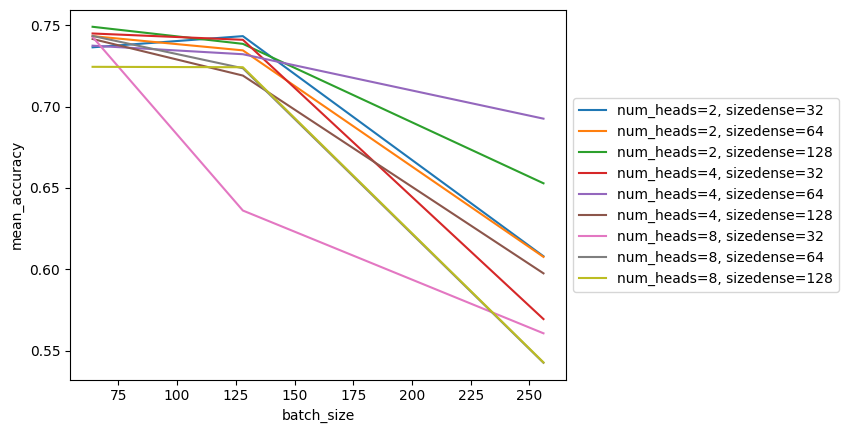

In [ ]:
fig, ax = plt.subplots()
for num_heads in param_grid['num_heads']:
    for fc_neurons in param_grid['sizedense']:
        accuracies = [result['mean_accuracy'] for result in results if result['num_heads'] == num_heads and result['sizedense'] == fc_neurons]
        ax.plot(param_grid['batch_size'], accuracies, label=f'num_heads={num_heads}, sizedense={fc_neurons}')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('batch_size')
ax.set_ylabel('mean_accuracy')
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Podemos observar que el tamaño del batch_size tiene un impacto en la exactitud del modelo. En promedio, se ha observado una reducción del 17% en la exactitud al aumentar el batch_size de 128 a 256. Además, se ha observado una ligera mejora en la exactitud al pasar de un batch_size de 128 a 64, lo que sugiere que un batch_size más pequeño de 64 es preferible.
<br><br>
En cuanto al número de heads, se ha encontrado que valores de 2 o 4 proporcionan mejores resultados en promedio. Por otro lado, el número de neuronas en la capa fully connected ha mostrado resultados mixtos, donde a veces un mayor número de neuronas ha dado mejores resultados y otras veces un menor número ha sido más efectivo.<br><br>
El mejor resultado obtenido fue con un batch_size de 64, num_heads de 2 y sizedense de 128, logrando una exactitud de 0.749.
</div>

## 2.4. Escala los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Ahora entrena el modelo con todos los datos disponibles (dejando un 80% para train y un 20% para test) con los mejores hyperparámetros identificados. Muestra además del mejor resultado, las gráficas de accuracy y loss durante el entrenamiento.
    
Comenta los resultados
</div>


In [ ]:
df['target'] = df['target'].replace({4: 1})

# Calculamos el mensaje más largo
max_length = max(len(seq) for seq in df['processed_text'])

X=df.processed_text
y=df.target

# Limitamos a 3000 tokens
num_words=3000
tok = Tokenizer(num_words=num_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = pad_sequences(sequences,maxlen=max_length)
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.2, random_state=123)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
model_tuned = create_model(2, 128, sizedense2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
history = model_tuned.fit(X_train, Y_train, batch_size=64, epochs=20, validation_split=0.1, callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/20
18000/18000 [==============================] - 211s 11ms/step - loss: 0.4572 - accuracy: 0.7819 - val_loss: 0.4417 - val_accuracy: 0.7943 - lr: 0.0010
Epoch 2/20
18000/18000 [==============================] - 187s 10ms/step - loss: 0.4356 - accuracy: 0.7963 - val_loss: 0.4366 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 3/20
18000/18000 [==============================] - 189s 10ms/step - loss: 0.4278 - accuracy: 0.8008 - val_loss: 0.4282 - val_accuracy: 0.7997 - lr: 0.0010
Epoch 4/20
18000/18000 [==============================] - 182s 10ms/step - loss: 0.4217 - accuracy: 0.8041 - val_loss: 0.4265 - val_accuracy: 0.8015 - lr: 0.0010
Epoch 5/20
18000/18000 [==============================] - 184s 10ms/step - loss: 0.4165 - accuracy: 0.8071 - val_loss: 0.4221 - val_accuracy: 0.8032 - lr: 0.0010
Epoch 6/20
18000/18000 [==============================] - 182s 10ms/step - loss: 0.4123 - accuracy: 0.8093 - val_loss: 0.4191 - val_accuracy: 0.8064 - lr: 0.0010
Epoch 7/20
18000/18000 [====

In [ ]:
# Evaluar modelo en test
test_loss_tuned, test_acc_tuned = model_tuned.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc_tuned)
print('Test loss:', test_loss_tuned)

10000/10000 [==============================] - 57s 6ms/step - loss: 0.4163 - accuracy: 0.8083
Test accuracy: 0.8082500100135803
Test loss: 0.4162658154964447


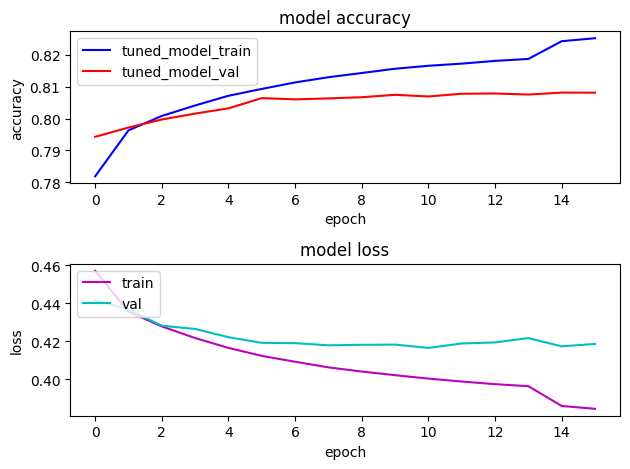

In [ ]:
plot_history(history,"tuned_model")

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Finalmente, hemos obtenido una precisión del 80.8% en el conjunto de prueba. El modelo se entrenó durante 16 épocas y utilizó el criterio de early stopping, deteniéndose después de 5 épocas sin mejorar la pérdida en la validación. En general, podemos afirmar que el modelo tiene un buen desempeño y predice correctamente la mayoría de las veces. Es importante tener en cuenta que el conjunto de datos proporcionado contiene textos que incluso para los humanos pueden resultar difíciles de determinar si son positivos o negativos.
<br><br>
Para mejorar aún más el modelo, se podrían considerar las siguientes estrategias: mejorar el preprocesamiento del texto (por ejemplo la eliminación de palabras comunes y poco informativas <i>stopwords</i> en inglés), explorar diferentes capas LSTM y arquitecturas, ajustar los hiperparámetros o utilizar transfer learning para utilizar modelos pre-entrenados con otros datos.
</div>

## 2.5. Extra 
Al tratarse Sentiment140 de un dataset público es habitual que los investigadores, equipos de data scientist o miembros de la comunidad de la ciencia de datos reporten los resultados obtenidos con sus nuevos algorítmos. En los últimos años se ha hecho popular una página web que reporta los resultados obtenidos por diferentes equipos junto con código reproducible: https://paperswithcode.com/sota/text-classification-on-sentiment140


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0 pt.]:</strong> Este apartado es un ejercicio extra que no es obligatorio realizar. Se trata de explorar los resultados reportados en la url indicada. Comprobarás que los resultados obtenidos están basados en modelos de lenguage de gran tamaño finetuneados sobre el dominio. Se anima al alumno a probar a cambiar la arquitectura utilizada o a utilizar alguno de los modelos y finetunearlo sobre el dominio con la ayuda de librerías como huggingface e intentar obtener resultados que se acerquen (¿o supéren?) a los benchmarks reportados.
</div>

In [ ]:
## Apartado extra opcional.

# 3. Ejercicio sobre traducción de textos (4 puntos)
En esta segunda parte vamos a utilizar una base de datos distinta para mostrar uno de los problemas en los que las arquitecturas basadas en transformers son más potentes: la conversión de secuencias a secuencias. En este caso lo vamos a entender como una traducción de un idioma a otro, pero esto es generalizable. Arquitecturas similares se podrían utilizar para convertir una secuencia larga (texto) a una secuencia (resumen), para reducir la complejidad de lectura de un texto, para transcribirlo a lenguaje de signos, etc.

## 3.1 Importación de los datos y preprocesamiento previo
En este caso la base de datos que se va a utilizar es la llamada WMT2014 English-French que contiene frases traducidas entre inglés y frances. 
Los datos se pueden descargar de:
https://paperswithcode.com/sota/machine-translation-on-wmt2014-english-french

Se trata de un fichero enorme. Por ello únicamente se van a utilzar un fragmento de todos los pares de frases del fichero. Se recomienda no cargar todos los datos simultaneamente para evitar problemas de memoria y de tiempo de computación.




<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong></p> Al igual que en casos anteriores, el primer paso es cargar y preprocesar los datos de la forma adecuada. Para ello se pide:
    
* Cargar las primeras 100.000 lineas del dataset proporcionado.
* Procesar el dataset de forma que se obtenga una lista de tuplas. El primer elemento de la tupla es la frase en inglés, el segundo elemento es la frase en frances. Al comienzo y final de la frase objetivo hay que añadir un caracter especial de comienzo [start] y fin de frase [end]: e.g. [start] lle découle de notre étonnement [end]
* Limpiar los datos de caracteres extraños, pasar a minusculas, etc.
* Mostrar varios pares de frases para comprobar que está correctamente procesado
* Toma al azar un 80% de los datos como train y el resto como test
* Comprueba que tus datos se llaman train_data y test_data  tienen la forma [(frase ingles, frase francés), (frase ingles,frase francés))  
* Ejecuta la celda que se ha proporcionado para vectorizar y codificar los datos.

</div>

In [ ]:
from datasets import load_dataset
dataset = load_dataset('wmt14', 'fr-en')

Extracting data files:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split:   0%|          | 0/40836715 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

Dataset wmt14 downloaded and prepared to /root/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Ejecutar esta celda si no quieres descargar todo el dataset de nuevo
from google.colab import drive
drive.mount('/content/drive')
home =  './drive/MyDrive/UOC/Deep_Learning/pec3/'
file_path = 'subset_dataset.csv'  # Ruta del archivo CSV en tu Google Drive
df1 = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargamos 100.000 datos
train_data = dataset['train'][:100000]
df = pd.DataFrame(train_data)

In [ ]:
# obtenemos la lista de tuplas, limpiamos los datos y pasamos a minusculas
start_token = '[start]'
end_token = '[end]'

def preprocess_data(row):
    english_sentence = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', row[0]['en'].lower())
    french_sentence = start_token + ' ' + re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', row[0]['fr'].lower()) + ' ' + end_token
    return (english_sentence, french_sentence)

data = df.apply(preprocess_data, axis=1).tolist()

In [ ]:
# Mostramos varios pares de frases para comprobar que está correctamente procesado
for i in range(5):
    print('English:', data[i][0])
    print('French:', data[i][1])
    print()

English: resumption of the session
French: [start] reprise de la session [end]

English: i declare resumed the session of the european parliament adjourned on friday  december  and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period
French: [start] je déclare reprise la session du parlement européen qui avait été interrompue le vendredi  décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez passé de bonnes vacances [end]

English: although as you will have seen the dreaded millennium bug failed to materialise still the people in a number of countries suffered a series of natural disasters that truly were dreadful
French: [start] comme vous avez pu le constater le grand bogue de lan  ne sest pas produit en revanche les citoyens dun certain nombre de nos pays ont été victimes de catastrophes naturelles qui ont vraiment été terribles [end]

English: you have requested a debate on this subject in the course of 

In [ ]:
from sklearn.model_selection import train_test_split
# Tomamos al azar un 80% de los datos como train: [(frase ingles, frase francés), (frase ingles,frase francés))
train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)
print('train_data length:', len(train_data))
print('test_data length:', len(test_data))
print('Example:', train_data[0])

train_data length: 80000
test_data length: 20000
Example: ('mr president the average citizen who hears about this debate on the chocolate directive will lick their lips at the thought of feasting on all kinds of delicacies', '[start] monsieur le président le citoyen moyen qui entend le présent débat afférent à la directive relative aux produits de cacao et de chocolat commence déjà à se lécher les babines à la pensée de se régaler et de faire bonne chair de toutes sortes de gourmandises [end]')


In [ ]:
###########################################################
# Esta celda para vectorizar los datos se propociona ######
###########################################################

vocab_size = 15000
sequence_length = 20
batch_size = 64

eng_vectorization = TextVectorization(max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,)
fr_vectorization = TextVectorization(max_tokens=vocab_size,output_mode="int",output_sequence_length=sequence_length + 1,)

train_eng_texts = [pair[0] for pair in train_data]
train_fr_texts = [pair[1] for pair in train_data]

eng_vectorization.adapt(train_eng_texts)
fr_vectorization.adapt(train_fr_texts)



def format_dataset(eng, fr):
    eng = eng_vectorization(eng)
    fr = fr_vectorization(fr)
    return ({"encoder_inputs": eng, "decoder_inputs": fr[:, :-1],}, fr[:, 1:])


def make_dataset(pairs):
    eng_texts, fr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fr_texts = list(fr_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_vectorized = make_dataset(train_data)

val_vectorized = make_dataset(test_data)


## 3.2. Modifica el bloque de transformer
A continuación se proporciona un bloque transformer del tipo seq2seq con un encoder y un decoder antes de la salida. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong></p> Se propone realizar algunos cambios sobre la implementación del bloque transformer:
    
* Añade una capa de atención de una sola cabeza al final del encoder.
* Añade una capa fully connected en el encoder
* Duplica el bloque encoder
* Añade una capa de dropout despues del bloque del decoder.

</div>

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.attention_2 = layers.MultiHeadAttention(num_heads=1, key_dim=embed_dim)  # Nueva capa de atención
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        # Nueva capa de atención
        attention_output_2 = self.attention_2(query=proj_output, value=proj_output, key=proj_output, attention_mask=padding_mask)
        proj_output_2 = self.layernorm_2(proj_output + attention_output_2)
        # Nueva capa fully connected
        fc_output = self.dense_proj(proj_output_2)
        return proj_output_2 + fc_output


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.5)  # Nueva capa de dropout
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(query=out_1,value=encoder_outputs,key=encoder_outputs,attention_mask=padding_mask,)
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_1)
        out_3 = self.layernorm_3(out_2 + proj_output)

        dropout_output = self.dropout(out_3)  # Capa de dropout

        return dropout_output

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    
    
embed_dim = 128
latent_dim = 1024
num_heads = 2

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)


# Duplicación del encoder
encoder_outputs_2 = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder_outputs_concat = layers.Concatenate()([encoder_outputs, encoder_outputs_2])

encoder = keras.Model(encoder_inputs, encoder_outputs_concat)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")


## 3.3. Entrena el modelo


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Entrena el modelo mostrando las gráficas de loss y accuracy. La accuracy no es una métricas que habitualmente se utilice en el entrenamiento de modelos de traducción. Lo habitual en este tipo de problemas sería utilizar la métrica BLEU basada en n-gramas (https://en.wikipedia.org/wiki/BLEU). Sin embargo, el bleu no está nativamente disponible en tensorflow para compilar el modelo así que como referencia se utilizará el accuracy que sería equivalente a la métrica de BLEU considerándo únicamente n-gramas de tamaño 1.

In [ ]:
# Compilar el modelo
transformer.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Entrenar el modelo
history = transformer.fit(
    train_vectorized,
    validation_data=val_vectorized,
    batch_size=batch_size,
    epochs=10
)

Epoch 1/10
1250/1250 [==============================] - 106s 75ms/step - loss: 5.1653 - accuracy: 0.1918 - val_loss: 4.3433 - val_accuracy: 0.2555
Epoch 2/10
1250/1250 [==============================] - 59s 47ms/step - loss: 4.3533 - accuracy: 0.2651 - val_loss: 3.9852 - val_accuracy: 0.2977
Epoch 3/10
1250/1250 [==============================] - 57s 45ms/step - loss: 4.0587 - accuracy: 0.2949 - val_loss: 3.7975 - val_accuracy: 0.3207
Epoch 4/10
1250/1250 [==============================] - 56s 45ms/step - loss: 3.8383 - accuracy: 0.3202 - val_loss: 3.6965 - val_accuracy: 0.3335
Epoch 5/10
1250/1250 [==============================] - 57s 45ms/step - loss: 3.7711 - accuracy: 0.3234 - val_loss: 3.6836 - val_accuracy: 0.3330
Epoch 6/10
1250/1250 [==============================] - 57s 46ms/step - loss: 3.6373 - accuracy: 0.3396 - val_loss: 3.6187 - val_accuracy: 0.3438
Epoch 7/10
1250/1250 [==============================] - 56s 45ms/step - loss: 3.5258 - accuracy: 0.3533 - val_loss: 3.5817 

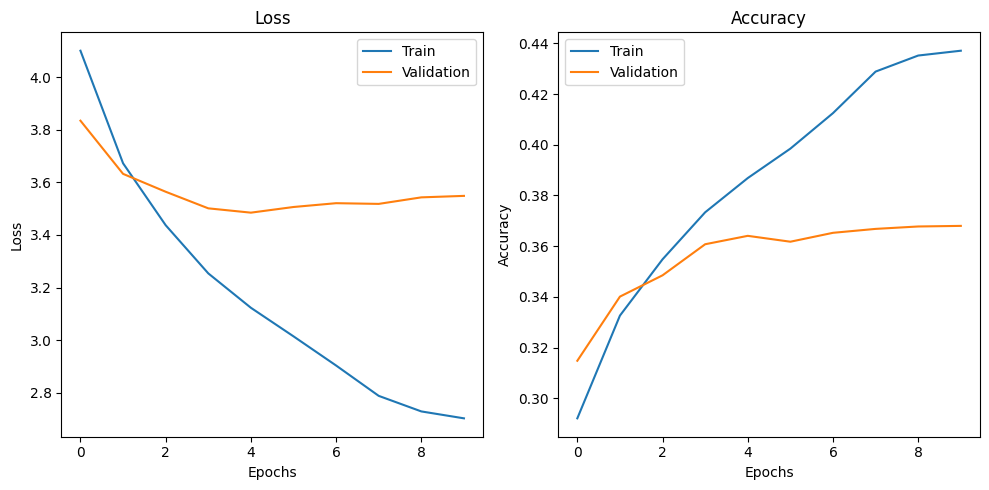

In [ ]:
plt.figure(figsize=(10,5))
# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])


# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.tight_layout()
plt.show()

## 3.4. Realiza una predicción sobre el dataset de test.
El modelo transformer es regresivo, esto quiere decir que para hacer la predicción se utiliza tanto el input de entrada como las predicciones ya realizadas. De hecho, este es uno de los principales motivos de las alucinaciones que sufren los modelos basados en transformers. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Se proporciona una funcion para decodificar una frase con el modelo entrenado . Hacer las modificaciones oportunas e importar las funciones necesarias para calcular el Bleu score sobre un subconjunto del test, por ejemplo sobre 100 frases.

Finalmente realiza alguna mejora a tu elección para conseguir un modelo con mejor Bleu (comprobándolo). Se puede añadir más datos al train, modificar la arquitectura, variar los hiperparámetros, etc. Se sugiere modificar el  dropout a un valor más habitual en la literatura. 
    
Compara tus resultados con los que aparecen en la url de paperswithcode y comentalos.

In [ ]:
###  Codigo proporcionado ###########
fr_vocab = fr_vectorization.get_vocabulary()
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = fr_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [2]:
from nltk.translate.bleu_score import corpus_bleu

# Cantidad de frases a evaluar
num_sentences = 100

# Obtener un subconjunto del test
test_subset = test_data[:num_sentences]

# Crear listas para almacenar las frases de referencia y las frases generadas
references = []
hypotheses = []

# Decodificar las frases del subconjunto del test
for sentence in test_subset:
    input_sentence, target_sentence = sentence
    decoded_sentence = decode_sequence(input_sentence)
    references.append([target_sentence.split()])
    hypotheses.append(decoded_sentence.split())

# Calcular el BLEU score
bleu_score = corpus_bleu(references, hypotheses)

print("BLEU score:", bleu_score)

BLEU score: 0.067185828221957


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
La precisión del modelo al utilizar la métrica de "accuracy" es de aproximadamente el 36%. Al observar algunas traducciones, se puede comprobar que son comprensibles y no difieren demasiado de la traducción perfecta. Sin embargo, esta métrica no es la más adecuada para evaluar las traducciones, por lo que se recomienda el uso de BLEU score.<br><br>
Podemos ver que los resultados en paperswithcode obtienen un BLEU score de hasta 46.4 de Microsoft. Por lo que se puede ver en el repositorio oficial, el preprocesado es más intenso y los transformadores mucho más complejos, por lo que es entendible que el BLEU score es considerablemente más elevado que el obtenido por mi modelo.
<br><br>
</div>